In [2]:
from numba_code import *
import matplotlib.pyplot as plt
plt.style.use('default')

## Examples of code use on the star
We start with a star graph with 4 demes. Its state is tracked by an array containing the number of mutant and wild-type indivudals that are in each deme. The first entry describes the center, the other describe the leaves.

For instance, $[[1,99],[0,100],[0,100],[0,100]]$ means:
- the center has one mutant and 99 wild-types
- the leaves have 100 mutants each.

In [3]:
#Initial state for the star.
in_numbers=np.array([[100.,0.],[0.,100.],[0.,100.],[0.,100.]]).astype(np.int64)
    
#Parameters
mO=0.01
mI=0.04
s=0.001
fitnesses=np.array([1+s,1])
nb_cycles=1000
t=5
N_demes=4
K=100
folder=None

The graph structure and its migration rates are specified through function migration_matrix. For a star, we use function define_star which takes parameters $m_0$ (outgoing migration rate from the center) and $m_I$ (ingoing migration rate in the center). The option "equal_contribution" is True if for each deme $i$, $\sum_j m_{ij}=1$ i.e. all demes contribute equally in average. It is False if for each deme $i$, $\sum_j m_{ji}=1$ i.e. all demes receive the same contribution in average.

In [4]:
#Migration matrix of the star
migration_matrix=define_star(N_demes,mI,mO, equal_contribution=True)

Building blocks of the code: 'growth_event' models the exponential growth in each deme, 'dilution_migration_event' models the dilution step and samples migrations.

In [5]:
#Examples of individual functions
grown_numbers=growth_event(in_numbers,fitnesses,t)
print('Graph state after growth: \n', grown_numbers)
diluted_numbers=dilution_migration_event(grown_numbers,migration_matrix,K)
print('\n Graph state after dilution/migration: \n', diluted_numbers)

Graph state after growth: 
 [[14915.70831584     0.        ]
 [    0.         14841.31591026]
 [    0.         14841.31591026]
 [    0.         14841.31591026]]

 Graph state after dilution/migration: 
 [[ 94   9]
 [  0 103]
 [  0  87]
 [  2 102]]


'fixation_probability' runs a number of simulations given by parameter 'nb_sim'. For each simulation, it starts with the initial state of the graph, and iterates cycles of growth / dilution, until the mutant is fixed or extinct.  The function returns three numbers :
- the average extinction time (computed on trajectories that ended in extinction)
- the average fixation time
- the ratio of fixations, i.e. probability of fixation

'fixation_probability' has an option 'save_dynamics'. If True, it saves the evolution of the state of the graph, for each simulation separately, into a folder specified as argument.

In [6]:
#Fixation probability 
nb_sim=1000
et, ft, fp = fixation_probability(in_numbers, folder, migration_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=100, print_frequency=500, save_dynamics=False)
print(f'Fixation probability on {nb_sim} simulations is {fp}, with \n average extinction time {et} and \n average fixation time {ft}')

Fixation probability on 1000 simulations is 0.261, with 
 average extinction time 141.9810554803789 and 
 average fixation time 733.1724137931035


In [7]:
#Trying one simulation with very large sizes and large fitness, from the experimental paper
numbers_exp=np.array([[0,1e7],[0,1e7],[1e4,1e7],[0,1e7]]).astype(np.int64)
mO=0.01
mI=0.04
N_demes=4
migration_matrix=define_star(N_demes,mI,mO, equal_contribution=True)
s=0.2
fitnesses=np.array([1+s,1])
nb_cycles=1000
t=5
K_exp=1e7
nb_sim=1
folder=None
et, ft, fp = fixation_probability(numbers_exp, folder, migration_matrix, fitnesses, nb_sim, nb_cycles, t, K_exp, size_follow_numbers=100, print_frequency=500, save_dynamics=False)
if fp >0:
    print(f'For one simulation, we have a fixation in {ft} steps')
else:
    print(f'For one simulation, we have an extinction in {et} steps')

For one simulation, we have a fixation in 31.0 steps


## Example with saved dynamics
When option 'save_dynamics' is True, we specify the number of bottleneck states we want to save by parameter 'size_follow_numbers', and the frequency by 'print_frequency'.

Example: if we want to save the first 500 steps, size_follow_numbers=500, print_frequency=1.

In [9]:
#Example while saving dynamics (option save_dynamics=True)
save_folder='Saved_dynamics'


#Initial state of the graph
in_numbers=np.array([[0.,100.],[0.,100.],[100.,0.],[0.,100.],[0.,100.]]).astype(np.int64)
    
#Parameters
mO=0.01
mI=0.04
s=0.001
fitnesses=np.array([1+s,1])
nb_cycles=10000
nb_sim=500
t=5
K=100
N_demes=5
migration_matrix=define_star(N_demes,mI,mO)
et, ft, fp = fixation_probability(in_numbers, save_folder, migration_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=1000, print_frequency=1, save_dynamics=True)

## Extracting saved dynamics

Folder 'Saved_dynamics' contains fixation trajectories up till the 1000th step, labeled as 'fix', and extinction trajectories labeled as 'ex'. 

In [10]:
#Upload one trajectory, gives an numpy array
fix1 = np.load("Saved_dynamics/fix_1.npz")['arr_0']

#Print elements of the array
print('Graph state after one cycle of growth/dilution: \n', fix1[0])
print('Graph state after 100 cycles of growth/dilution: \n', fix1[99])
print('Graph state after 500 cycles of growth/dilution: \n', fix1[499])

Graph state after one cycle of growth/dilution: 
 [[  3  97]
 [  0 113]
 [ 95   2]
 [  0 102]
 [  0  87]]
Graph state after 100 cycles of growth/dilution: 
 [[54 64]
 [12 69]
 [68 46]
 [40 75]
 [ 9 91]]
Graph state after 500 cycles of growth/dilution: 
 [[ 90   0]
 [111   0]
 [ 94   0]
 [107   0]
 [ 95   0]]


In [11]:
#Number of mutants in deme 0 (i.e. center) in the first 500 steps of the dynamics
center_mutant=fix1[:500,0,0]

#Number of wild-types in deme 0 (i.e. center) in the first 500 steps of the dynamics
center_WT=fix1[:500,0,1]

#Ratio of mutant in deme 0 (center) in the first 500 steps of the dynamics
center_ratioM=center_mutant/(center_WT+center_mutant)

In [12]:
#Ratio of mutant in leaf 2, that is initially all mutant
leaf2_mutant=fix1[:500,2,0]
leaf2_WT=fix1[:500,2,1]
leaf2_ratioM=leaf2_mutant/(leaf2_WT+leaf2_mutant)

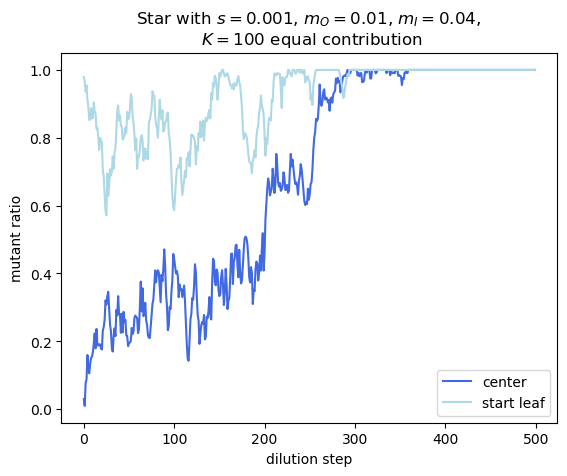

In [13]:
#Evolution of the ratio of mutants in the center
plt.plot(np.arange(0,500,1),center_ratioM, color='royalblue', label='center')
plt.plot(np.arange(0,500,1),leaf2_ratioM, color='lightblue', label='start leaf')
plt.ylabel('mutant ratio')
plt.xlabel('dilution step')
plt.title('Star with $s=0.001$, $m_O=0.01$, $m_I=0.04$, \n $K=100$ equal contribution')
plt.legend()